In [12]:
import pandas as pd
import polars as pl
import torch
from utils.plot_utils import set_theme, predict
from data import KFoldEncodeModule
from torchmetrics import R2Score, MeanSquaredError
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

set_theme()

In [13]:
from lightning_model import Netlightning

model = Netlightning.load_from_checkpoint(
    "../runs/regression_bloom/bloom2013_regression/bloom2013_regression-epoch=38-step=15327.ckpt",
    loss_function="mse",
)
model.eval()

Netlightning(
  (net): Net(
    (activation): GELU(approximate='none')
    (sequence): Sequential(
      (0): Linear(in_features=6078, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=1024, out_features=512, bias=True)
      (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
      (6): Linear(in_features=512, out_features=256, bias=True)
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): GELU(approximate='none')
      (9): Linear(in_features=256, out_features=128, bias=True)
      (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): GELU(approximate='none')
      (12): Dropout(p=0.8992, inplace=False)
      (13): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (train_

In [14]:
train = "Bloom2013"
test = "Bloom2015"
filename="../data/regression_data/bloom2015_regression.feather"

In [15]:
data = pd.read_feather(filename)
data.drop(columns=["Strain"], inplace=True)
variation_columns = [col for col in data.columns if col.startswith("Y")]
data.head()

,YAL001C,YAL002W,YAL003W,YAL004W,YAL005C,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,...,latent_56,latent_57,latent_58,latent_59,latent_60,latent_61,latent_62,latent_63,Phenotype,Condition
0,0,0,0,0,0,0,0,0,0,0,...,-1.701524,-2.37987,3.69037,3.703681,-1.473729,2.430254,0.682125,-1.826363,-2.253831,CoCl2
1,0,0,0,0,0,0,0,0,0,0,...,-1.701524,-2.37987,3.69037,3.703681,-1.473729,2.430254,0.682125,-1.826363,-1.887746,CoCl2
2,0,1,0,1,1,1,1,1,1,1,...,-1.701524,-2.37987,3.69037,3.703681,-1.473729,2.430254,0.682125,-1.826363,2.415068,CoCl2
3,0,1,0,1,1,1,1,1,1,1,...,-1.701524,-2.37987,3.69037,3.703681,-1.473729,2.430254,0.682125,-1.826363,2.417437,CoCl2
4,0,1,0,1,1,1,1,1,1,1,...,-1.701524,-2.37987,3.69037,3.703681,-1.473729,2.430254,0.682125,-1.826363,-0.634514,CoCl2


In [16]:
from sklearn.model_selection import train_test_split

_, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [17]:
results_df = pd.DataFrame(columns=["Compound", "MSE", "R-squared"])

# fig, axes = plt.subplots(5, 8, figsize=(16,12), sharex=True, sharey=True, tight_layout=True)

pred_dict = dict()
mse = MeanSquaredError()
r2 = R2Score()

for i, key in enumerate(test_data.Condition.unique()):
    
    condition_test = test_data[test_data["Condition"] == key]
    X = torch.tensor(condition_test.drop(["Condition","Phenotype"], axis=1).values).float()
    y = torch.tensor(condition_test["Phenotype"].values).float().unsqueeze(1)
    
    y_pred = predict(model, X).to("cpu")

    mse_val = mse(y_pred, y).detach().item()
    r2_val = r2(y_pred, y).detach().item()
    
    print(f"{key}", end=": ")
    print(f"MSE:  {mse_val:.2f}", " | ", f"R2: , {r2_val:.2f}")
    
    pred_dict[key] = y_pred.reshape(-1).detach().numpy()
    
    results_df.loc[i] = [key, mse_val, r2_val]
    

ethanol: MSE:  0.92  |  R2: , -3.24
Trehalose: MSE:  1.09  |  R2: , -0.81
Raffinose: MSE:  0.66  |  R2: , -0.48
Zeocin: MSE:  13.59  |  R2: , -15.00
Menadione: MSE:  0.81  |  R2: , -0.19
hydroxyurea: MSE:  1.96  |  R2: , -10.58
MnSO4: MSE:  1.36  |  R2: , -0.54
berbamine: MSE:  11.33  |  R2: , -11.61
Neomycin: MSE:  18.99  |  R2: , -31.99
CuSO4: MSE:  1.92  |  R2: , -3.51
Indoleacetic acid: MSE:  0.58  |  R2: , -0.52
lactate: MSE:  0.65  |  R2: , -0.34
CoCl2: MSE:  3.77  |  R2: , -3.14
xylose: MSE:  0.69  |  R2: , -0.27
Lactose: MSE:  1.23  |  R2: , -1.37
MgCl2: MSE:  0.24  |  R2: , -0.19
Diamide: MSE:  9.15  |  R2: , -12.56
formamide: MSE:  0.69  |  R2: , -0.22


In [18]:
results_df["Compound"] = results_df["Compound"].astype(str)
print(results_df[["MSE", "R-squared"]].apply(lambda x: str(x.mean()) + " ± " + str(x.std()), axis=0))

MSE          3.868502770033148 ± 5.5208422035367315
R-squared    -5.364388273821937 ± 8.298535615984209
dtype: object


Text(0.5, 0.98, 'Bloom2013 Model on Bloom2015')

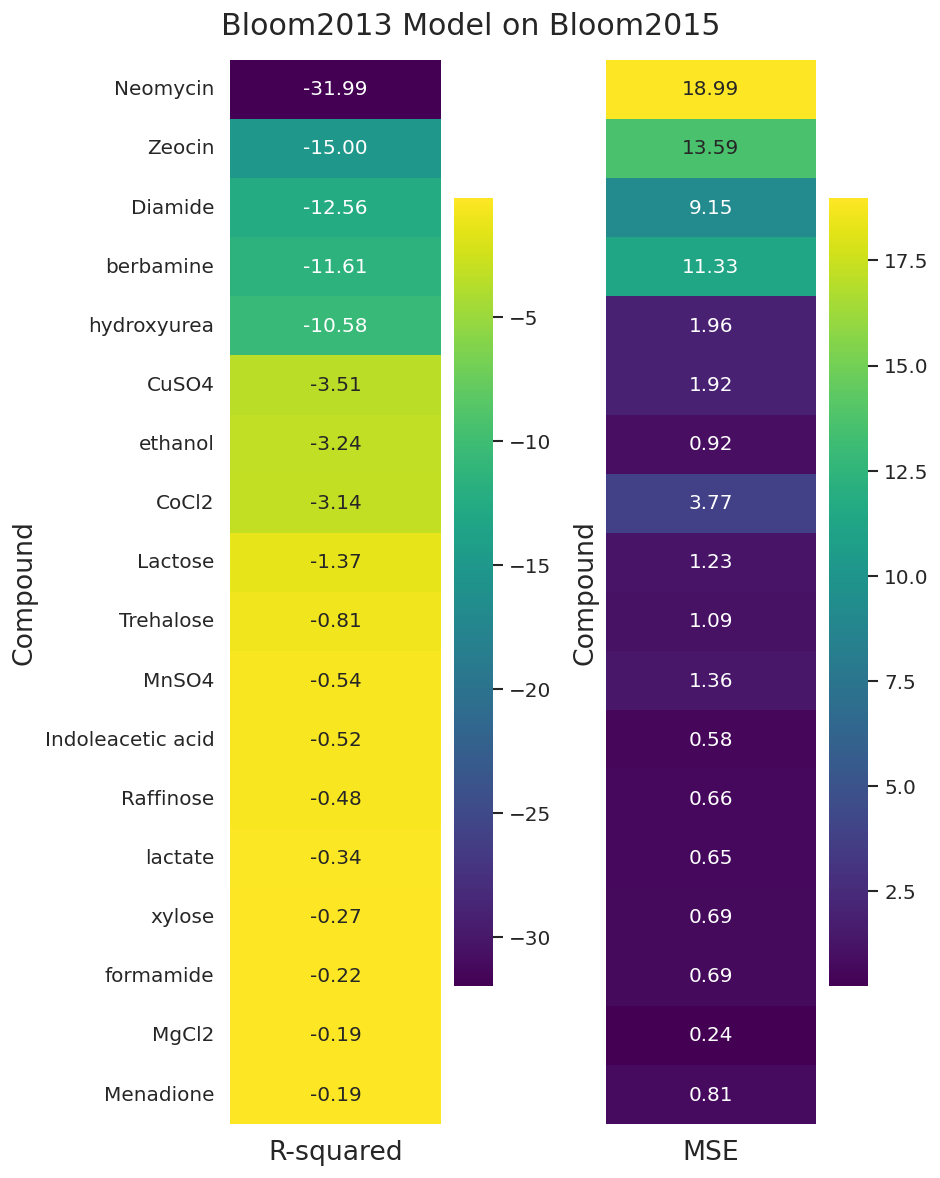

In [19]:
fig2, ax = plt.subplots(1,2,figsize=(8,10), sharey=True, tight_layout=True)

sns.heatmap(results_df.set_index('Compound').drop(['MSE'], axis=1).sort_values('R-squared'), cmap='viridis', annot=True, fmt='.2f', ax=ax[0])
sns.heatmap(results_df.set_index('Compound').sort_values('R-squared').drop(['R-squared'], axis=1), cmap='viridis', annot=True, fmt='.2f', ax=ax[1])
plt.suptitle(f"{train} Model on {test}", size=18)

Text(0.5, 0, 'True')

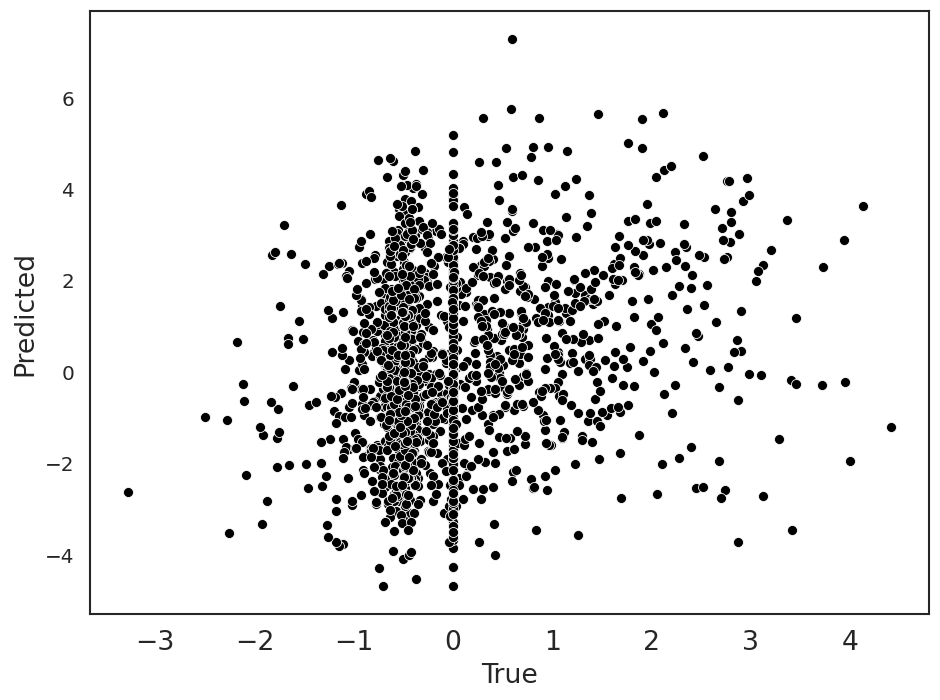

In [20]:
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)

condition = "CoCl2"
sns.scatterplot(x=test_data[test_data["Condition"] == condition]["Phenotype"], y=pred_dict[condition])
ax.set_ylabel("Predicted")
ax.set_xlabel("True")


Text(0.5, 1.0, 'Histogram of phenotype values')

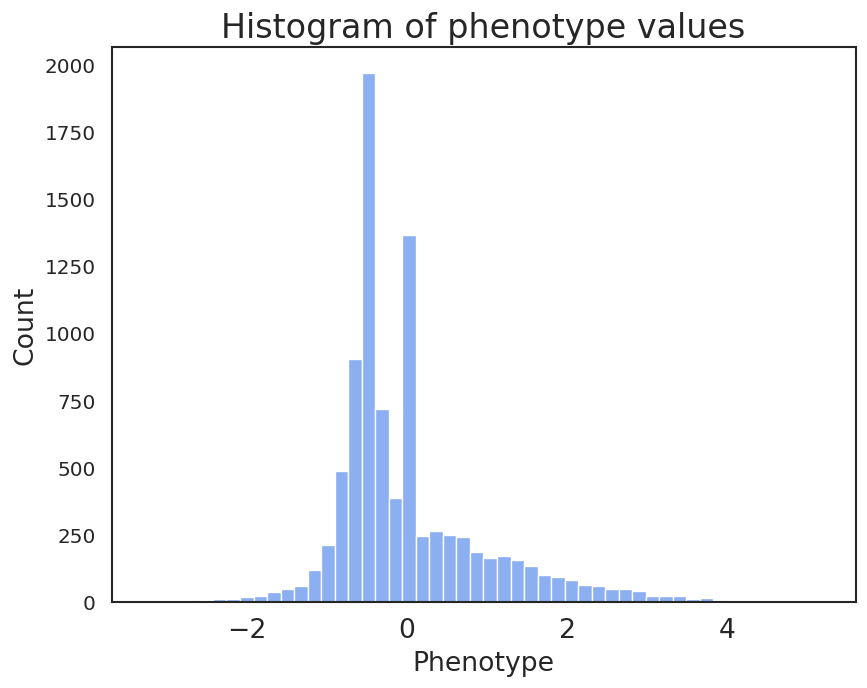

In [25]:
sns.histplot(x = data[data["Condition"] == condition]["Phenotype"], bins=50, color="cornflowerblue")
plt.title("Histogram of phenotype values")

Text(0.5, 1.0, 'Histogram of phenotype values - Test Set')

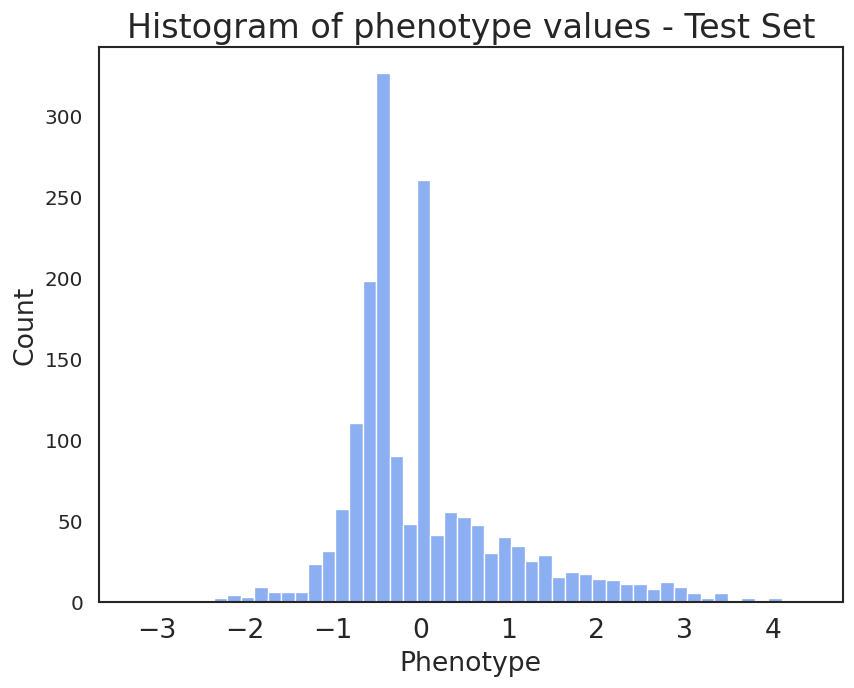

In [26]:
sns.histplot(x = test_data[test_data["Condition"] == condition]["Phenotype"], bins=50, color="cornflowerblue")
plt.title("Histogram of phenotype values - Test Set")